# IST597:- Multi-Layer Perceptron

## Load the libraries

In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
seed_val = 2218
np.random.seed(seed_val)
tf.random.set_seed(seed_val)

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Generate random data

In [3]:
#downloading the dataset

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
size_input = train_images[0].shape[0] * train_images[0].shape[1]
size_hidden = 256
size_hidden_2 = 128
size_output = 10
learning_rate_hp = 1e-3
number_of_train_examples = train_images.shape[0]
number_of_test_examples = test_images.shape[0]
train_batch = 60
test_batch = 10
lamda = 0.7
NUM_EPOCHS = 3000

In [5]:
def one_hot_encode(vec):
  n = len(vec)
  out = np.zeros((n, 10))
  for i in range(n):
    out[i, vec[i]] = 1
  return out

In [6]:
X_train = train_images.reshape(train_images.shape[0], -1)
X_test = test_images.reshape(test_images.shape[0], -1)

y_train = np.reshape(train_labels, (number_of_train_examples, 1))
y_test = np.reshape(test_labels, (number_of_test_examples, 1))
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

print(X_train.shape, " ", y_train.shape)

#standardizing the images

x_train = X_train / 255.0
x_test = X_test / 255.0

(60000, 784)   (60000, 10)


In [ ]:
# Split dataset into batches
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(10)

## Build MLP using Eager Execution

In [7]:
def compute_accuracy(mlp, X_test, y_test):
  '''
  This function does a forward pass of x, then checks if the indices
  of the maximum value in the output equals the indices in the label 
  y. Then it sums over each prediction and calculates the accuracy.
  '''
  predictions = []
  # for x, y in zip(X_test, y_test):
  #   x = tf.reshape(x, (1, size_input))
  #   output = mlp.forward(x)
  #   pred = np.argmax(output)
  #   predictions.append(pred == np.argmax(y))

  output = mlp.forward(X_test)
  pred = np.argmax(output, axis=1)
  predictions.append(pred == np.argmax(y_test, axis=1))

  return np.mean(predictions)

In [13]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_hidden_2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden, size_hidden_2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))
     # Initialize weights between input layer and hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden_2]))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden_2]))
    # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    l2_rg = (lamda / (2.0 * number_of_train_examples)) * (np.sum(np.square(self.variables[0])) + np.sum(np.square(self.variables[1])) + np.sum(np.square(self.variables[2])))
    #l1_rg = (lamda / number_of_train_examples) * (np.sum(self.variables[0]) + np.sum(self.variables[1]) + np.sum(self.variables[2]))
    return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf) + l2_rg
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    #print(self.variables)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_hp)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
      # L2 Regularization
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer 1
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.sigmoid(what)
    # Compute values in hidden layer 2
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.sigmoid(what_2)
    # Compute output
    output = tf.matmul(hhat_2, self.W3) + self.b3
    output = tf.nn.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model

In [9]:
from tensorflow.python.ops.nn_impl import compute_average_loss
# Initialize model using GPU
mlp = MLP(size_input, size_hidden, size_hidden_2, size_output, device='gpu')
error = []
accuracy = []
time_start = time.time()
for epoch in range(NUM_EPOCHS + 1):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  # train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(train_batch)

  preds = mlp.forward(X_train)
  loss_total = loss_total + mlp.loss(preds, y_train)
  lt = lt + mlp.loss(preds, y_train)
  gd = mlp.backward(X_train, y_train)
  '''
  This code is for batch gradient descent
  '''
  '''
  mlp.vanillasgd(gd)
  for inputs, outputs in train_ds:
    preds = mlp.forward(inputs)
    #print(inputs.shape, " ", outputs.shape, " ", preds.shape)
    loss_total = loss_total + mlp.loss(preds, outputs)
    lt = lt + mlp.loss(preds, outputs)
    gd = mlp.backward(inputs, outputs)
    #mlp.vanillasgd(gd)
  '''
  curr_error = np.sum(loss_total) / X_train.shape[0]
  error.append(curr_error)
  curr_accuracy = compute_accuracy(mlp, X_test, y_test) * 100
  accuracy.append(curr_accuracy)
  if(epoch % 100 == 0):
    print('Number of Epoch = {} - Average Error:= {} - Accuracy:= {:.2f}%'.format(epoch + 1, curr_error, curr_accuracy))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average Error:= 11.47461875 - Accuracy:= 9.12%
Number of Epoch = 101 - Average Error:= 2.25425546875 - Accuracy:= 68.96%
Number of Epoch = 201 - Average Error:= 2.0086016927083334 - Accuracy:= 74.17%
Number of Epoch = 301 - Average Error:= 1.91281640625 - Accuracy:= 76.30%
Number of Epoch = 401 - Average Error:= 1.8549825520833334 - Accuracy:= 77.55%
Number of Epoch = 501 - Average Error:= 1.8192165364583333 - Accuracy:= 78.13%
Number of Epoch = 601 - Average Error:= 1.794733203125 - Accuracy:= 78.45%
Number of Epoch = 701 - Average Error:= 1.7754037760416668 - Accuracy:= 78.62%
Number of Epoch = 801 - Average Error:= 1.7615903645833333 - Accuracy:= 78.98%
Number of Epoch = 901 - Average Error:= 1.7499489583333334 - Accuracy:= 79.15%
Number of Epoch = 1001 - Average Error:= 1.74370625 - Accuracy:= 79.28%
Number of Epoch = 1101 - Average Error:= 1.7323908854166667 - Accuracy:= 79.29%
Number of Epoch = 1201 - Average Error:= 1.7257450520833333 - Accuracy:= 79.58%
Nu

Predicted output:=  3
Actual ouput:=  3


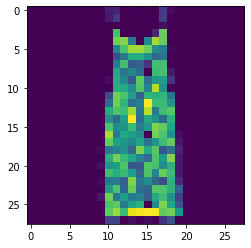

In [10]:
test_index = 300
test_data = tf.reshape(X_test[test_index], (1, size_input))
output = mlp.forward(test_data)
pred = np.argmax(output, axis=1)
print("Predicted output:= ", int(pred))
print("Actual ouput:= ", test_labels[test_index])
plt.imshow(test_images[test_index])

[9.120000000000001, 9.87, 10.639999999999999, 11.37, 12.32, 13.170000000000002, 14.63, 15.57, 17.080000000000002, 17.849999999999998, 19.17, 20.96, 21.45, 22.509999999999998, 23.82, 25.1, 26.900000000000002, 28.199999999999996, 30.28, 31.94, 33.81, 35.23, 36.69, 38.15, 39.17, 40.08, 41.65, 42.699999999999996, 43.9, 44.99, 45.87, 47.15, 47.94, 48.76, 49.519999999999996, 50.4, 51.23, 51.59, 52.190000000000005, 53.06999999999999, 53.349999999999994, 54.35, 54.620000000000005, 55.32, 55.57, 56.43, 56.49999999999999, 57.220000000000006, 57.699999999999996, 58.02, 58.45, 58.589999999999996, 59.06, 59.06, 59.540000000000006, 59.88, 59.89, 60.440000000000005, 60.56, 61.1, 61.260000000000005, 61.79, 62.08, 62.419999999999995, 62.81, 62.83, 63.38, 63.29, 63.43, 63.44, 63.73, 63.89, 64.53, 64.25999999999999, 64.8, 65.02, 65.56, 65.52, 65.77, 65.55, 65.86, 65.8, 66.60000000000001, 66.57, 66.78, 66.97, 67.06, 67.30000000000001, 67.35, 67.42, 67.64, 67.69, 67.83, 67.85, 67.96, 67.65, 68.28, 68.15, 6

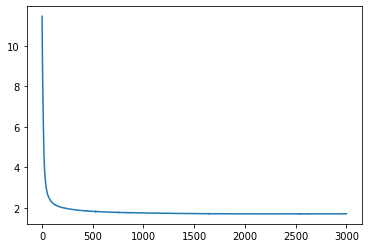

In [11]:
print(accuracy)
# plt.plot(error, [i for i in range(NUM_EPOCHS + 1)])
plt.plot([i for i in range(NUM_EPOCHS + 1)], error)

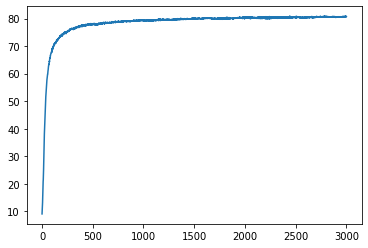

In [12]:
plt.plot([i for i in range(NUM_EPOCHS + 1)], accuracy)